In [14]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
# from dataset import get_rays

## Getting Direction and Origin, Also Camera to World Coordinates

In [15]:
# 1. make a mesh grid (u,v). say camera is sitting along the z-axis at distance f. 
# from that calculate the direction. say some pixel is at position u,v and
# grid corrdinate origin is at (e/2, h/2). then the distance is terms of 
# x,y,z coordinate would be (u-w/2), (v-h/2), f . then invert the (v-h/2).
# now what we this is according to the assumed camera position. but we
# have the pose of the camera, so we would have to multiply by rotation
# matrix to consider the camera pose. then once we rotate, now we can
# divide by the magnitude of the distance we have calculated earlier 
# to get the unit vector and that unt vector gives us the direction? or rays_d ?

# Yes, the understanding above is correct:
    
# 1. create a mesh grid(um,v): This grid represents the pixel coordinates in the image
# 2. calculate direction in camera's local space: The camera's local space assumes the camera is positioned
# along the negative z-axis at a distance of f (focal length).

# from that point (3d coordinate of point on image plane would be given as: (u-(w/2), -(v-h/2), -f). 
                 
# 3. rotate to consider camera pose. since the camera may not be aligned with the negative z-axis in the world space. 
#                  we need to consider its actual oritentation. 
#                  This is done by multiplying the local directions by the rotation matrix from the pose
#                  (camera-to-world matri)
                 
# 4. nromalize to get the unit vectors: the world-space coordinates are nrormalized to have unit length, turning
#                  them into unit vectors that represents the direction of the rays. these are rays_d
                 

In [16]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def get_rays(datapath, mode='train'):
    
    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)
    
    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))
    
    images = []
    
    for i in range(N):
        name = pose_file_names[i]
        
        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)
        
        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)
        
        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    # print("images.shape before concatenation", images.shape)
    
    # 90 images with shape (1,400,400, 4)
    print("images[0].shape, len(images)",images[0].shape, len(images))
    images = np.concatenate(images)
    print("images.shape after concatenation", images.shape)
    
    H = images.shape[1]
    W = images.shape[2]
    
    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))
    
    for i in range(N):
        
        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
        
        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    print("rays_o.shape", rays_o.shape)
    print("rays_d.shape", rays_d.shape)
    print("target_px_values.shape",target_px_values.shape)
    return rays_o, rays_d, target_px_values


In [17]:
get_rays('fox')

/tmp/ipykernel_168301/1323450238.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


images[0].shape, len(images) (1, 400, 400, 4) 90
images.shape after concatenation (90, 400, 400, 4)
rays_o.shape (90, 160000, 3)
rays_d.shape (90, 160000, 3)
target_px_values.shape (90, 160000, 3)


(array([[[ 7.35889149, -6.92579079,  4.95830917],
         [ 7.35889149, -6.92579079,  4.95830917],
         [ 7.35889149, -6.92579079,  4.95830917],
         ...,
         [ 7.35889149, -6.92579079,  4.95830917],
         [ 7.35889149, -6.92579079,  4.95830917],
         [ 7.35889149, -6.92579079,  4.95830917]],
 
        [[ 0.9987492 ,  0.        ,  9.94999981],
         [ 0.9987492 ,  0.        ,  9.94999981],
         [ 0.9987492 ,  0.        ,  9.94999981],
         ...,
         [ 0.9987492 ,  0.        ,  9.94999981],
         [ 0.9987492 ,  0.        ,  9.94999981],
         [ 0.9987492 ,  0.        ,  9.94999981]],
 
        [[ 1.89063346,  4.04017401,  8.94999981],
         [ 1.89063346,  4.04017401,  8.94999981],
         [ 1.89063346,  4.04017401,  8.94999981],
         ...,
         [ 1.89063346,  4.04017401,  8.94999981],
         [ 1.89063346,  4.04017401,  8.94999981],
         [ 1.89063346,  4.04017401,  8.94999981]],
 
        ...,
 
        [[-4.88392639,  8.71921825

## Part where we need to Render

In [18]:
import torch

def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)     
    
    # we are concatetating 1 which value of accumualted transmittance at first sample. T(0) = 1
    # and then j goes from summation to i-1, so it is [:,:-1]
    
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cuda', white_bckgr=True):
    
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))
    
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]    
    
    colors, density = model.intersect(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3))
    
    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
        
    weights = compute_accumulated_transmittance(1 - alpha) * alpha # [nb_rays, nb_bins]
    
    if white_bckgr:   # this white background regulairzation is very important, and without it
        # results can be very bad. 
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
        weight_sum = weights.sum(-1) # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    
    return c

In [19]:
from tqdm import tqdm

def training(mdoel, optimizer, scheduler, tn,tc,nb_bins, nb_epochs, data_loader, device = 'cuda'):
    training_loss = []
    for epoch in range(nb_epochs):
        
        for batch in tqdm(data_loader):
            
            o = batch[:,:3].to(device)
            d = batch[:, 3:6].to(device)
            
            target = batch[:, 6:].to(device)
            
            prediction = rendering(model, o,d,tn,tf, nb_bins = nb_bins, device = device)
            
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            
        scheduler.step()
        
    return training_loss

In [20]:
class Nerf(nn.Module):
    
    def __init__(self, Lpos = 10, Ldir = 4, hidden_dim = 256):
        
        super(Nerf, self).__init__()
        
        # +3 because of positional encoding plus P as inputs; p are three directions x,y,z so 3 added. Think so.. 
        # block1, we implemented 5 dimensions.
        self.block1 = nn.Sequential(nn.Linear(Lpos*6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        
        # what happens at 6th block.. # plus 1 because of sigma (density)
        # also there are d directions
        
        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos*6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim+1))
        
        # this Ldir*6 is coming from architecture.. which is addition of direction. +3 is from p. 
        self.rgb_head= nn.Sequential(nn.Linear(hidden_dim + Ldir *6 + 3, hidden_dim//2), nn.ReLU(),
                      nn.Linear(hidden_dim//2, 3), nn.Sigmoid())
        
        self.Lpos = Lpos
        self.Ldir = Ldir

    def positional_encoding(self, x, L):
        out = [x]
        
        for j in range(L):
                
            out.append(torch.sin(2 **j *x))
            out.append(torch.cos(2 **j *x))
                       
        return torch.cat(out, dim = 1)
                       

               
        
    def forward(self, xyz, d):
                
        x_emb = self.positional_encoding(xyz, self.Lpos) # [batch_size, Lpos*6+3]
        d_emb = self.positional_encoding(d, self.Ldir) # [batch_size, Ldir*6=4+3]
                
        h = self.block1(x_emb) #[batch_size, hidden_dim]
        h = self.block2(torch.cat((h,x_emb), dim=1)) # [batch_size, hidden_dim +1]
        
        # get the density back
        sigma = h[:, -1]
        h = h[:,:-1] # [batch_size, hidden_dim +1]
        c = self.rgb_head(torch.cat((h,d_emb), dim=1))
        
        return c, torch.relu(sigma)
                
    def intersect(self, x, d):
        return self.forward(x, d)
        

In [21]:
batch_size = 1024
o,d, target_px_values = get_rays('fox', mode = 'train')

dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1,3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1,3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1,3).type(torch.float)), dim = 1),
                        batch_size = batch_size, shuffle = True)

test_o, test_d, test_target_px_values = get_rays('fox', mode = 'test')
                            
print("test_o.shape, test_d.shape, test_target_px_values.shape",test_o.shape, test_d.shape, test_target_px_values.shape)

# for 1st epoch, we just trian from the center of the aimge. 
dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90,400,400,3)[:,100:300, 100:300,:].reshape(-1,3).type(torch.float),
                                          torch.from_numpy(d).reshape(90,400,400,3)[:,100:300, 100:300,:].reshape(-1,3).type(torch.float),
                                          torch.from_numpy(target_px_values).reshape(90,400,400,3)[:,100:300, 100:300,:].reshape(-1,3).type(torch.float)),dim = 1),
                                         batch_size = batch_size, shuffle = True)

test_o, test_d, test_target_px_values  = get_rays('fox' , mode = 'test')

/tmp/ipykernel_168301/1323450238.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


images[0].shape, len(images) (1, 400, 400, 4) 90
images.shape after concatenation (90, 400, 400, 4)
rays_o.shape (90, 160000, 3)
rays_d.shape (90, 160000, 3)
target_px_values.shape (90, 160000, 3)
images[0].shape, len(images) (1, 400, 400, 4) 10
images.shape after concatenation (10, 400, 400, 4)
rays_o.shape (10, 160000, 3)
rays_d.shape (10, 160000, 3)
target_px_values.shape (10, 160000, 3)
test_o.shape, test_d.shape, test_target_px_values.shape (10, 160000, 3) (10, 160000, 3) (10, 160000, 3)
images[0].shape, len(images) (1, 400, 400, 4) 10
images.shape after concatenation (10, 400, 400, 4)
rays_o.shape (10, 160000, 3)
rays_d.shape (10, 160000, 3)
target_px_values.shape (10, 160000, 3)


In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


device = 'cuda'

tn = 8
tf = 12
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf().to(device)
print(f"Total number of trainable parameters: {count_parameters(model)}")  # Print the total parameters





Total number of trainable parameters: 595844


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10], gamma = gamma)


training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device = device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn,tf, nb_bins, nb_epochs, dataloader, device = device)
plt.plot(training_loss)
plt.show()

In [ ]:
checkpoint_path = "model_checkpoint_state_dict_nerf_v1.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")
torch.save(model, 'model_nerf')

In [12]:
# img = rendering(model, torch.from_numpy(o[0]).to(device), torch.from_numpy(d[0]).to(device),
#                 tn,tf,nb_bins=100, device = device)

# plt.imshow(img.reshape(400,400,3).data.cpu().numpy())



OutOfMemoryError: CUDA out of memory. Tried to allocate 7.51 GiB (GPU 0; 14.62 GiB total capacity; 7.88 GiB already allocated; 6.57 GiB free; 7.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
test_o, test_d, test_target_px_values  = get_rays('fox' , mode = 'test')


/tmp/ipykernel_168301/1323450238.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


images[0].shape, len(images) (1, 400, 400, 4) 10
images.shape after concatenation (10, 400, 400, 4)
rays_o.shape (10, 160000, 3)
rays_d.shape (10, 160000, 3)
target_px_values.shape (10, 160000, 3)


In [25]:
device = 'cuda'
tn = 8
tf = 12

model = torch.load('model_nerf')

In [26]:
model

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=257, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
img = rendering(model, torch.from_numpy(o[2]).to(device), torch.from_numpy(d[2]).to(device),
                tn,tf,nb_bins=100, device = device)

plt.imshow(img.reshape(400,400,3).data.cpu().numpy())



In [35]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))
    


# there are 16 million points. 400*400 grid, and 100 bins
# 400*400*100 = 16000000 = 16 million
# chunk ito 1.6 mil and 1.6 mil
@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [36]:
img, mse, psnr = test(model, torch.from_numpy(test_o[0]).to(device).float(), torch.from_numpy(test_d[0]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[0].reshape(400, 400, 3))

print(psnr)

32.589866974737724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


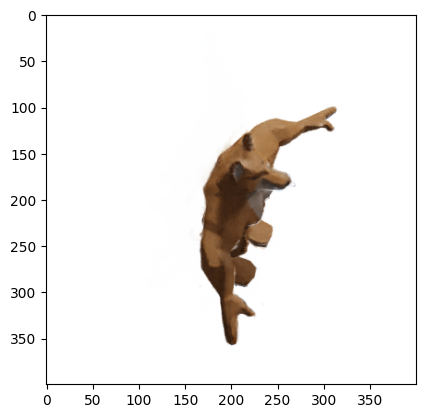

In [37]:
plt.imshow(img)

In [38]:
test_o[0].shape # (160000, 3)

# these will be lists, which will have part of the data. 
torch.from_numpy(test_o[0]).chunk(10)


(tensor([[ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         ...,
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500]], dtype=torch.float64),
 tensor([[ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         ...,
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500]], dtype=torch.float64),
 tensor([[ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         ...,
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500]], dtype=torch.float64),
 tensor([[ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
         ...,
         [ 3.7897, -1.3840,  9.1500],
         [ 3.7897, -1.3840,  9.1500],
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


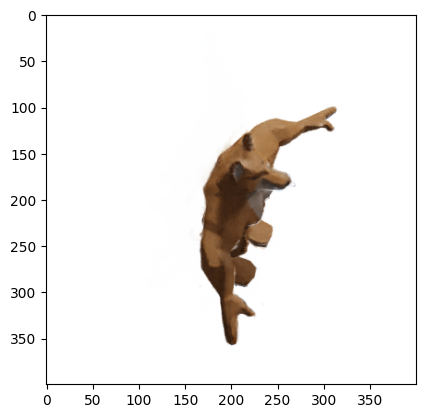

In [39]:
plt.imshow(img)  # this is the image geenrated by the model. we can compare it with the test image. 

In [40]:
plt.imshow(text_target_px_values[0].reshape(400,400,3))

NameError: name 'text_target_px_values' is not defined

In [ ]:
plt.imshow(img-test_target_px_values[0].reshape(400,400,3))

In [ ]:
## PSNR.. 

In [ ]:
mse


In [ ]:
mse2psnr(mse)  # 32.95 psnr is good. 